In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import GammaPrior
from edbo.bro import BO

%matplotlib inline

In [65]:
from data_loader import suzuki, casp15

test_casp15 = casp15()

print("CASP15 Dataset: ")
print(test_casp15)

CASP15 Dataset: 
      AL0_P  TM-score  TM-align  AL4_P    QCS  Z-score  Handed.     SS   DFM  \
0     77.78     0.794     0.797  88.89  87.09     7.43     0.91  0.463  0.17   
1     36.47     0.410     0.444  41.76  53.52     2.81     0.91  0.520  0.37   
2     72.17     0.888     0.893  87.39  97.86    12.90     0.94  0.650  0.09   
3     95.50     0.921     0.924  98.20  97.10     8.25     0.95  0.678  0.04   
4     57.27     0.571     0.569  64.55  67.85     3.86     0.92  0.462  0.22   
...     ...       ...       ...    ...    ...      ...      ...    ...   ...   
3999  95.50     0.929     0.932  98.20  97.33     8.25     0.95  0.694  0.04   
4000  95.93     0.972     0.972  96.83  99.00    10.91     0.97  0.780  0.05   
4001  95.50     0.943     0.946  98.20  97.77     8.25     0.96  0.698  0.04   
4002   0.00     0.388     0.405   0.00  26.25     0.84     0.80  0.204  0.32   
4003  88.33     0.733     0.733  98.33  79.79     5.93     0.90  0.429  0.06   

      GDT_TS  
0      

### Data Preprocessing

In [57]:
from edbo.utils import Data
from data_loader import suzuki, casp15

casp15 = Data(casp15()) # load casp data

casp15.drop(['AL0_P', 'QCS', 'Z-score', 'SS', 'DFM']) # drop unwanted columns 

# Standardize (normalize, etc)
casp15.standardize(target='GDT_TS', scaler='minmax')

# Drop highly correlated features
#casp15.uncorrelated(target='GDT_TS', threshold=0.95)

print(casp15.data[:1000])

     TM-score  TM-align   AL4_P   Handed.  GDT_TS
0    0.780742  0.768944  0.8889  0.847826   76.92
1    0.335267  0.330435  0.4176  0.847826   38.38
2    0.889791  0.888199  0.8739  0.913043   70.54
3    0.928074  0.926708  0.9820  0.934783   91.89
4    0.522042  0.485714  0.6455  0.869565   55.45
..        ...       ...     ...       ...     ...
995  0.932715  0.929193  0.9820  0.956522   91.67
996  0.783063  0.782609  0.8204  0.760870   75.60
997  0.814385  0.804969  0.9658  0.891304   79.92
998  0.372390  0.335404  0.5182  0.826087   44.32
999  0.587007  0.557764  0.9167  0.847826   75.83

[1000 rows x 5 columns]


### Bayesian Optimization

In [58]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=12,                              # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

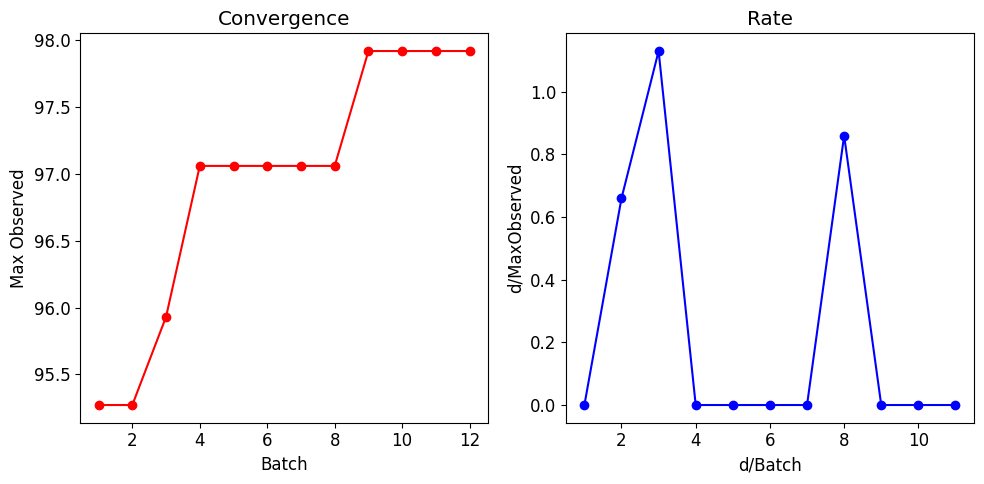

Model Performance:
RMSE: 4.54145678078247
R2_score: 0.956339482805358

Actual GDT_TS:
0       76.92
1       38.38
2       70.54
3       91.89
4       55.45
        ...  
3999    92.57
4000    96.49
4001    95.05
4002    48.33
4003    82.08
Name: GDT_TS, Length: 4004, dtype: float64

Predicted GDT_TS:
[80.196655 41.095337 79.36435  ... 94.114136 49.593315 82.89125 ]


In [59]:
import matplotlib.pyplot as plt
from edbo.math_utils import model_performance

# Plot convergence
bo.plot_convergence()

acq_summary = bo.acquisition_summary()

# predicted GDT_TS
GDT_TS_pred_mu = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain)) # GP posterior mean
GDT_TS_pred_var = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 2 # GP posterior variance

# true GDT_TS
GDT_TS_actual = casp15.data['GDT_TS']

RMSE, R2_score = model_performance(GDT_TS_pred_mu, GDT_TS_actual)

print(f"Model Performance:\nRMSE: {RMSE}\nR2_score: {R2_score}")

print("\nActual GDT_TS:")
print(GDT_TS_actual)

print("\nPredicted GDT_TS:")
print(GDT_TS_pred_mu)


True Maximum: 97.92
Predicted Maximum: 97.01018524169922


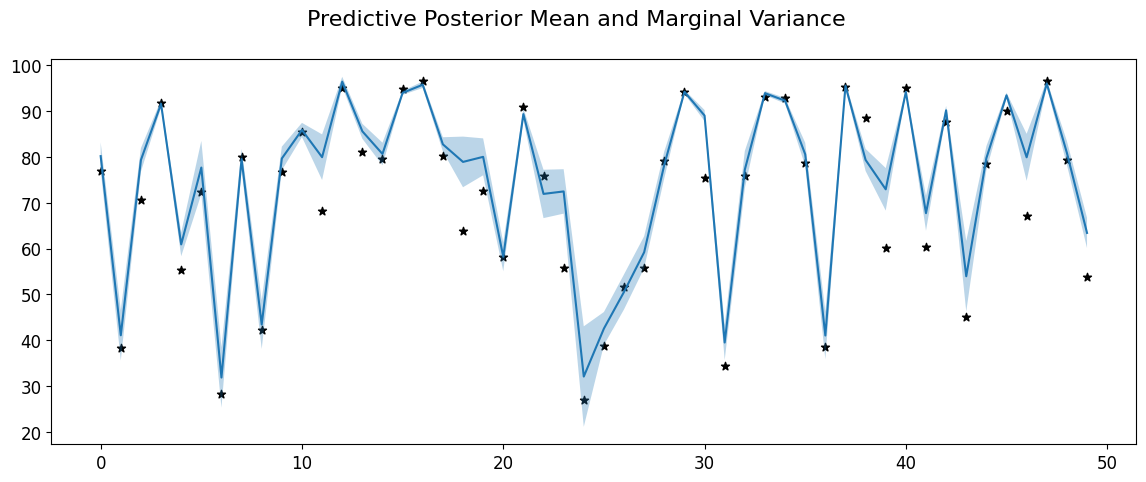

In [60]:
import matplotlib.pyplot as plt

x_star = range(4004)

#generate the plots
fig = plt.figure(figsize=(14,5))
fig.suptitle('Predictive Posterior Mean and Marginal Variance', fontsize=16)
ax = fig.add_subplot(111)

ax.scatter(x_star[:50], GDT_TS_actual[:50], marker='*', color='k')
ax.plot(GDT_TS_pred_mu[:50], color='C0')
ax.fill_between(x=x_star[:50], y1=GDT_TS_pred_mu[:50]+GDT_TS_pred_var[:50], y2=GDT_TS_pred_mu[:50]-GDT_TS_pred_var[:50], alpha=0.3);

# predicted maxima
print(f"True Maximum: {max(GDT_TS_actual)}")
print(f"Predicted Maximum: {max(GDT_TS_pred_mu)}")

In [61]:
import matplotlib.pyplot as plt
from edbo.math_utils import pca

# Run PCA on the dataset
explained_variance = pca(bo.obj.domain, n_components=1)

Explained variance = 0.9109307942103152


In [ ]:
# strategy 1: Generate x* and plot mu, var for 1 or 2 variables


# strategy 2: Run PCA and generate x* along the axis of the principle component


# strategy 3: Run t-SNE to reduce dimension to N components and generate x* in the lower-dim space



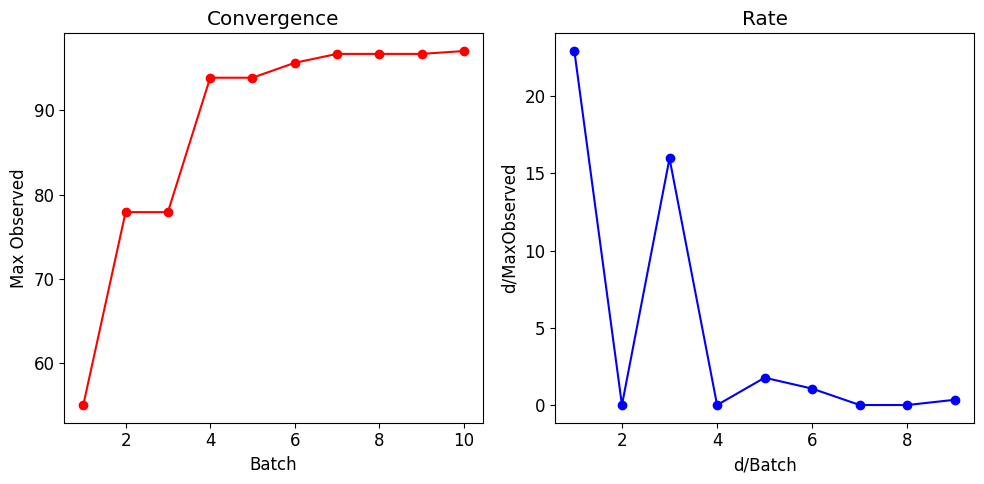

In [49]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                        # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=1,                               # Choose 1 experiments on each iteraiton 
        acquisition_function='TS',                  # Use expected improvement
        init_method='rand',
        fast_comp=True)                             # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

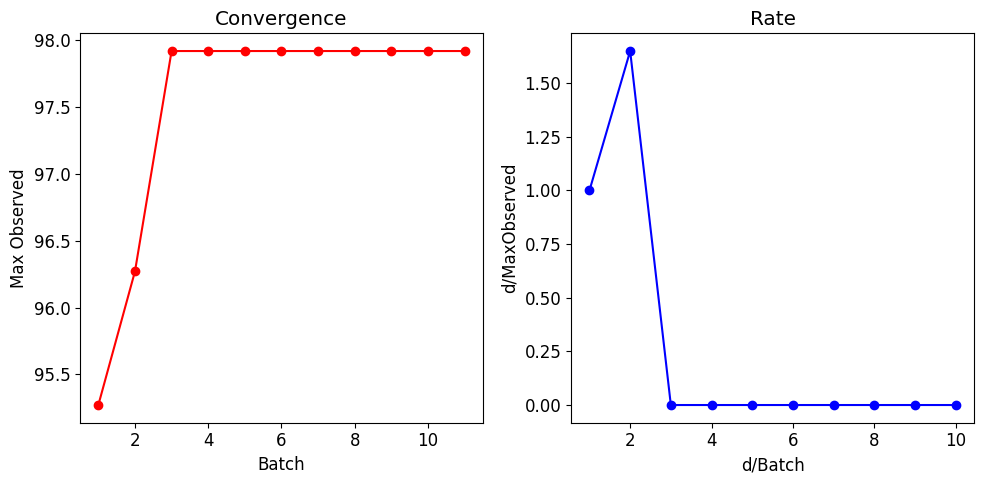

In [33]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp15.data,                      # Experiment index to look up results from
        domain=casp15.data.drop('GDT_TS', axis=1),  # Reaction space
        batch_size=20,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',              # Use expected improvement
        fast_comp=True)                         # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

### Simulations

In [34]:
from edbo.models import GP_Model, RF_Model, Random
from edbo.plot_utils import average_convergence, plot_avg_convergence
import pandas as pd

# Function for simulating different BO parameters

def simulate(data,                 # Data container (vide supra)
             acq_func,             # Acquisition function: 'EI', 'PI', 'UCB', 'TS', ...
             model=GP_Model,       # Surrogate model: GP_Model or RF_Model
             init_method='rand',   # Initialization method: 'rand', 'pam', 'kmeans'
             batch_size=1,        # Parallel acquisition: int
             iterations=9,         # Number of iterations to run each simulation for
             average_of=10,        # Number of simulations to average
             export_path=None,     # Export the simulation results to a CSV file
             plot=False):          # Plot the average and standard deviation averaged convergence
    """
    Simulation function which averages BO runs with given optimization paramters.
    """
    
    # Average N optimizations with different random initializations
    results = []
    for i in range(average_of):
        
        print(f"Experiment {i+1}/{average_of}...")
        
        # Use random function if the acquisition function is random selection
        if acq_func == 'rand':
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    init_method=init_method,
                    model=Random,
                    batch_size=batch_size,
                    acquisition_function=acq_func)
        # Otherwise use specified model
        else:
            bo = BO(exindex=data.data,
                    domain=data.data.drop('GDT_TS', axis=1),
                    model=model,
                    init_method=init_method,
                    batch_size=batch_size,
                    acquisition_function=acq_func,
                    fast_comp=True)                            # Use gpytorch fast computation features
            
        # Simulate
        bo.init_seq.visualize = False
        bo.simulate(iterations=iterations, seed=i)
        
        # Append results to record
        results.append(bo.obj.results_input()['GDT_TS'].values)
        
    # Save the results to a CSV file
    results = pd.DataFrame(results)
    if export_path != None:
        results.to_csv(export_path)
        
    # Average performance
    index, mean, std = average_convergence(results, batch_size)
    
    # Plot
    if plot:
        plot_avg_convergence(results, batch_size)
        
    return results, mean, std

Acquisition Function: TS
Experiment 1/15...
Experiment 2/15...
Experiment 3/15...
Experiment 4/15...
Experiment 5/15...
Experiment 6/15...
Experiment 7/15...
Experiment 8/15...
Experiment 9/15...
Experiment 10/15...
Experiment 11/15...
Experiment 12/15...
Experiment 13/15...
Experiment 14/15...
Experiment 15/15...


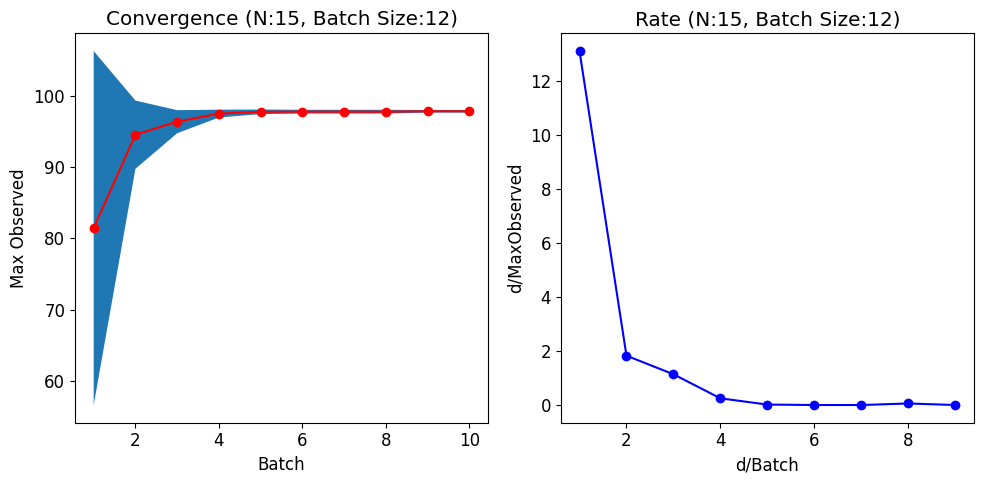

Acquisition Function: rand
Experiment 1/15...
Experiment 2/15...
Experiment 3/15...
Experiment 4/15...
Experiment 5/15...
Experiment 6/15...
Experiment 7/15...
Experiment 8/15...
Experiment 9/15...
Experiment 10/15...
Experiment 11/15...
Experiment 12/15...
Experiment 13/15...
Experiment 14/15...
Experiment 15/15...


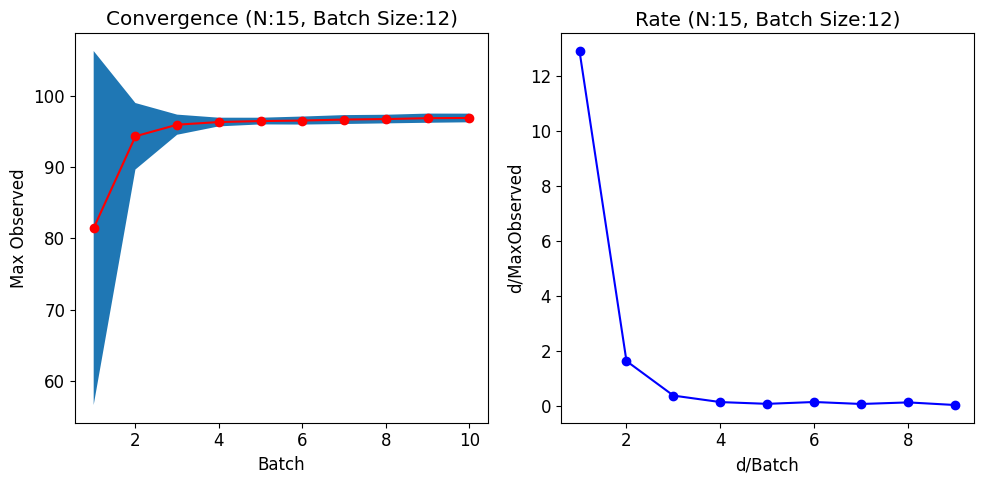

Acquisition Function: eps-greedy
Experiment 1/15...
Experiment 2/15...
Experiment 3/15...
Experiment 4/15...
Experiment 5/15...
Experiment 6/15...
Experiment 7/15...
Experiment 8/15...
Experiment 9/15...
Experiment 10/15...
Experiment 11/15...
Experiment 12/15...
Experiment 13/15...
Experiment 14/15...
Experiment 15/15...


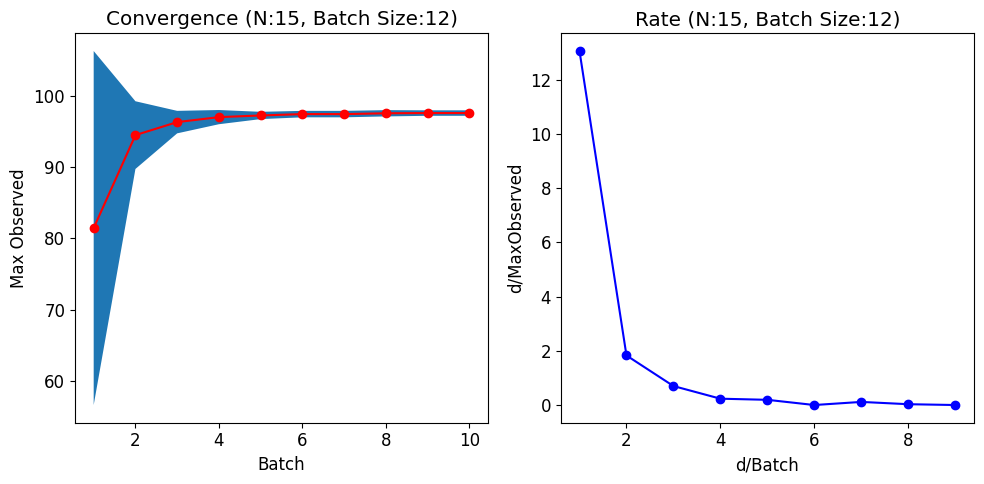

Acquisition Function: MeanMax
Experiment 1/15...
Experiment 2/15...
Experiment 3/15...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new

Experiment 4/15...
Experiment 5/15...
Experiment 6/15...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 7/15...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagona

Experiment 8/15...
Experiment 9/15...
Experiment 10/15...
Experiment 11/15...
Experiment 12/15...


C:\Users\lucap\anaconda3\envs\edbo\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


Experiment 13/15...
Experiment 14/15...
Experiment 15/15...


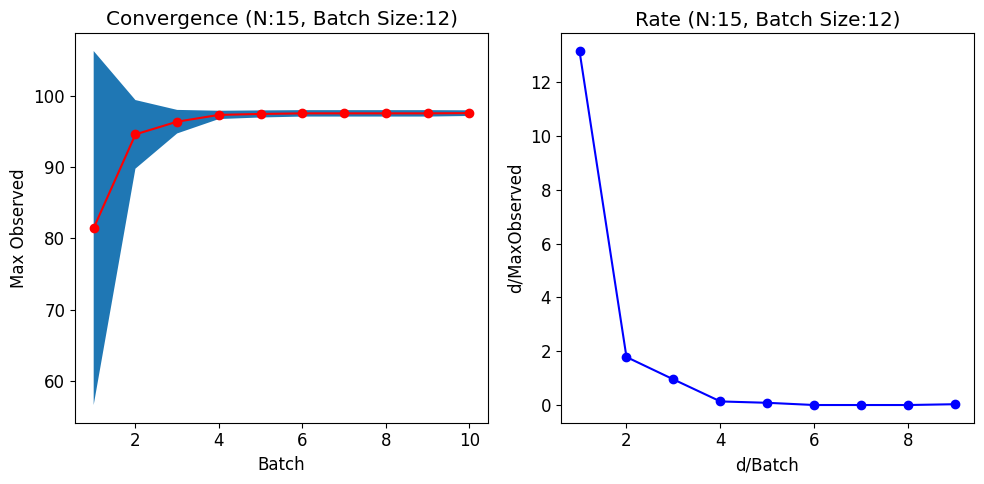

Acquisition Function: VarMax
Experiment 1/15...
Experiment 2/15...
Experiment 3/15...
Experiment 4/15...
Experiment 5/15...
Experiment 6/15...
Experiment 7/15...
Experiment 8/15...
Experiment 9/15...
Experiment 10/15...
Experiment 11/15...
Experiment 12/15...
Experiment 13/15...
Experiment 14/15...
Experiment 15/15...


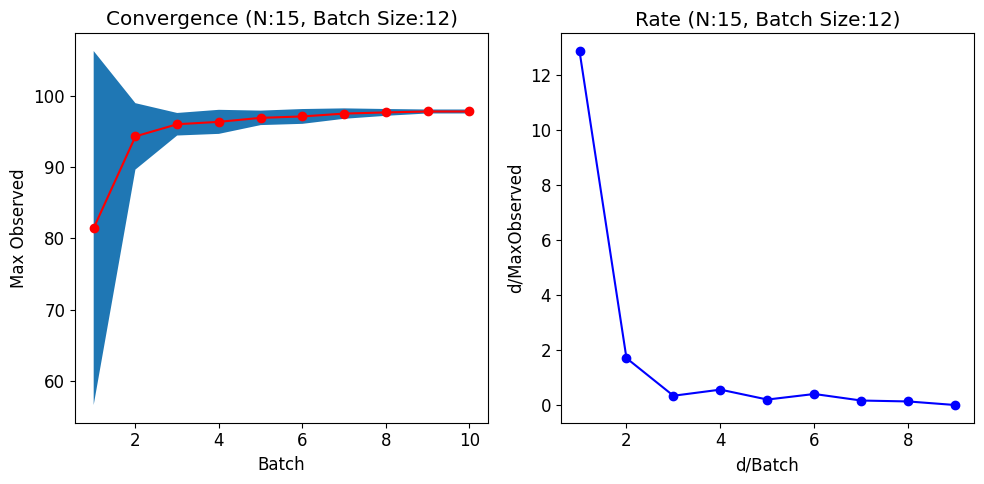

Average performance for all acquisition functions:


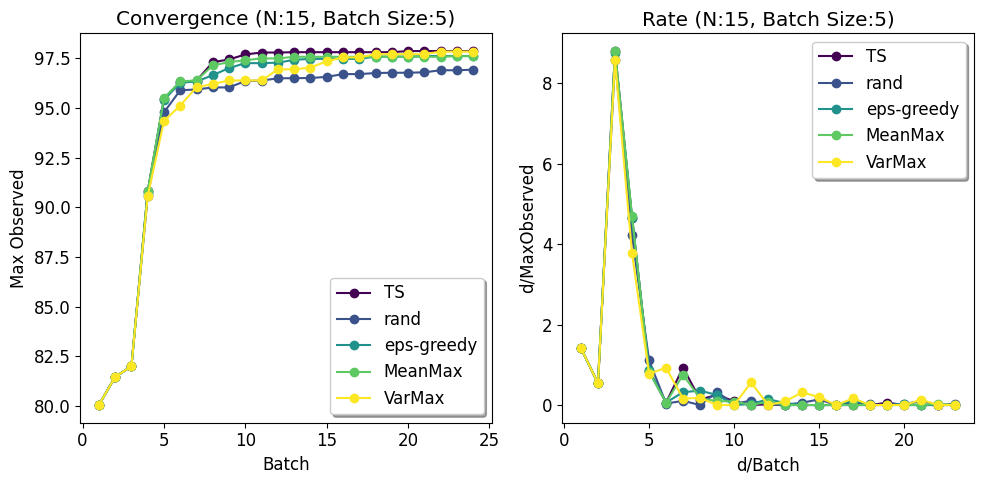

In [36]:
from edbo.plot_utils import compare_convergence

# Simulation

acq_funcs = ['TS', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp15,          # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=12,        # Choose 5 experiments at a time
                              iterations=9,        # Run for 9 iterations
                              average_of=15,       # Run with 15 different random seeds
                              export_path=None,    # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 5, acq_funcs)

#### Ideas

- Visualise the surrogate model space (posterior) after certain numbers of iterations to show exploration/exploitation
- Visualise the separation of the data in space for a few features